In [60]:
# 1. 필요한 라이브러리 임포트
import cv2
import numpy as np
import easyocr
from PIL import Image
import matplotlib.pyplot as plt
import ast
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import os
import uuid
from pathlib import Path
import io
import base64
from langchain.prompts import load_prompt
from langchain_community.chat_models import ChatOpenAI
from dotenv import load_dotenv
import requests

In [170]:
# .env 파일 로드
load_dotenv(override=True)

True

In [62]:
source_lang = "ko"
target_lang = "en"
model = "gpt-4.1"
image_path = "test3.jpg"  # 파일 경로

# 1. 파일을 바이트로 읽기
with open(image_path, 'rb') as file:
    contents = file.read()

# 2. 바이트를 numpy 배열로 변환
nparr = np.frombuffer(contents, np.uint8)

# 3. OpenCV 이미지로 디코드
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

In [129]:
def ocr_image_upstage(filename):
    url = "https://api.upstage.ai/v1/document-digitization"
    headers = {"Authorization": f"Bearer {os.getenv('UPSTAGE_API_KEY')}"}

    files = {"document": open(filename, "rb")}
    data = {"model": "ocr"}
    response = requests.post(url, headers=headers, files=files, data=data)

    print("원본 OCR 결과:", response.json())
 
    ocr_results = []
    
    for word in response.json()["pages"][0]["words"]:
        # 바운딩 박스 좌표 추출
        vertices = word["boundingBox"]["vertices"]
        bbox = [[vertex["x"], vertex["y"]] for vertex in vertices]
        text = word["text"]
        
        # 튜플로 묶어서 ocr_results에 추가
        ocr_results.append((bbox, text))
    
    print("원본 OCR 결과:")
    for result in ocr_results:
        print(result)
    
    # 바운딩 박스 통합 처리
    merged_results = merge_adjacent_bboxes(ocr_results)
    
    print("\n통합된 OCR 결과:")
    for result in merged_results:
        print(result)
        
    return merged_results

def merge_adjacent_bboxes(ocr_results, y_threshold=10, x_threshold=25):
    if not ocr_results:
        return []

    # 1. y좌표 네 꼭짓점 모두 비교해서 줄 그룹핑
    lines = []
    for bbox, text in ocr_results:
        bbox_y_center = sum([p[1] for p in bbox]) / 4
        found = False
        for line in lines:
            line_y_center = line['y_center']
            if abs(bbox_y_center - line_y_center) <= y_threshold:
                line['items'].append((bbox, text))
                found = True
                break
        if not found:
            lines.append({'y_center': bbox_y_center, 'items': [(bbox, text)]})

    merged_results = []
    for line in lines:
        # 2. x좌표 순서대로 정렬
        print("줄 그룹:", [text for _, text in line['items']])
        items = sorted(line['items'], key=lambda x: x[0][0][0])
        current_group = [items[0]]
        for i in range(1, len(items)):
            prev_bbox = current_group[-1][0]
            curr_bbox = items[i][0]
            # x좌표 인접성 검사
            if curr_bbox[0][0] - prev_bbox[1][0] <= x_threshold:
                current_group.append(items[i])
            else:
                merged_bbox, merged_text = merge_group(current_group)
                merged_results.append((merged_bbox, merged_text))
                current_group = [items[i]]
        if current_group:
            merged_bbox, merged_text = merge_group(current_group)
            merged_results.append((merged_bbox, merged_text))
    return merged_results

def merge_group(group):
    """
    그룹 내의 바운딩 박스들과 텍스트를 통합합니다.
    x좌표 순서대로 정렬하여 텍스트를 통합합니다.
    """
    if not group:
        return None, ""
    
    # x좌표 기준으로 그룹 재정렬
    sorted_group = sorted(group, key=lambda x: x[0][0][0])
    
    # 모든 바운딩 박스의 좌표를 고려하여 새로운 바운딩 박스 생성
    all_x = []
    all_y = []
    merged_text = []
    
    for bbox, text in sorted_group:  # sorted_group 사용
        for point in bbox:
            all_x.append(point[0])
            all_y.append(point[1])
        merged_text.append(text)
    
    # 새로운 바운딩 박스 좌표 계산
    min_x = min(all_x)
    max_x = max(all_x)
    min_y = min(all_y)
    max_y = max(all_y)
    
    merged_bbox = [
        [min_x, min_y],  # 좌상단
        [max_x, min_y],  # 우상단
        [max_x, max_y],  # 우하단
        [min_x, max_y]   # 좌하단
    ]
    
    # 텍스트 통합 (x좌표 순서대로 정렬된 상태)
    merged_text = " ".join(merged_text)
    
    return merged_bbox, merged_text

In [63]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_deepseek import ChatDeepSeek
 
def get_model_by_name(model_name):
    if model_name.startswith("gpt-"):
        return ChatOpenAI(model_name=model_name, temperature=0), model_name
        # return ChatOpenAI(model_name="gpt-4.1", temperature=0), "gpt-4.1"
    elif model_name == "gpt":
        return ChatOpenAI(model_name="gpt-4.1", temperature=0), "gpt-4.1"
    elif model_name.startswith("claude-"):
        return ChatAnthropic(model_name=model_name, temperature=0), model_name
    elif model_name == "claude":
        return ChatAnthropic(model_name="claude-3-5-haiku-latest", temperature=0), "claude-3-5-haiku-latest"
    elif model_name == "deepseek":
        return ChatDeepSeek(model_name="deepseek-chat", temperature=0), "deepseek-chat"
    elif model_name.startswith("deepseek-"):
        return ChatDeepSeek(model_name=model_name, temperature=0), model_name
    else:
        return ChatOpenAI(model_name="gpt-4.1", temperature=0), "gpt-4.1"

In [64]:
# 결과 정제
def clean_content(content):
    # 첫 번째 '[' 위치 찾기
    start_idx = content.find('[')
    if start_idx == -1:  # '[' 가 없는 경우
        return content
    
    # '[' 이후의 내용만 추출
    cleaned_content = content[start_idx:]
    return cleaned_content

In [81]:
def create_mask(image, bbox, margin=2):
    """바운딩 박스 영역의 마스크 생성 (마진 추가)"""
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # bbox 형식 확인
    if not (isinstance(bbox, list) and len(bbox) == 4 and all(isinstance(pt, (list, tuple)) and len(pt) == 2 for pt in bbox)):
        print("잘못된 bbox 형식:", bbox)
        return mask  # 빈 마스크 반환
    
    # 바운딩 박스 좌표를 정수로 변환 및 마진 추가
    int_bbox = [[int(round(x)), int(round(y))] for x, y in bbox]
    expanded_bbox = [
        [max(0, int_bbox[0][0] - margin), max(0, int_bbox[0][1] - margin)],
        [min(image.shape[1], int_bbox[1][0] + margin), max(0, int_bbox[1][1] - margin)],
        [min(image.shape[1], int_bbox[2][0] + margin), min(image.shape[0], int_bbox[2][1] + margin)],
        [max(0, int_bbox[3][0] - margin), min(image.shape[0], int_bbox[3][1] + margin)]
    ]
    
    # 마스크 생성
    pts = np.array(expanded_bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    return mask

def get_text_color(inpainted_image , image, bbox, contrast_threshold=30):
    """바운딩 박스 영역에서 텍스트 색상 추출"""
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]

    # 인페인팅된 이미지에서 배경색 추출
    inpainted_roi = inpainted_image[y1:y2, x1:x2]
    if inpainted_roi.size == 0:
        return (0, 0, 0)

    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return (0, 0, 0)

    h, w, _ = roi.shape
    center_y = h // 2
    center_row = roi[center_y, :]  # 중앙 row만 추출

    # 색상 카운팅
    reshaped = center_row.reshape(-1, 3)
    color_counts = Counter(map(tuple, reshaped))
    most_common_colors = color_counts.most_common(10)  # 상위 10개

    # 인페인팅된 영역에서 가장 흔한 색상을 배경색으로 사용
    reshaped_inpainted = inpainted_roi.reshape(-1, 3)
    inpainted_color_counts = Counter(map(tuple, reshaped_inpainted))
    bg_color = inpainted_color_counts.most_common(1)[0][0]  # 가장 많이 나타나는 색상

    # 배경색과의 대비 계산
    def contrast(c1, c2):
        return abs(int(np.mean(c1)) - int(np.mean(c2)))

    # 대비 높은 색상 필터링
    filtered_colors = [
        color for color, _ in most_common_colors
        if contrast(color, bg_color) >= contrast_threshold
    ]

    if filtered_colors:
        return filtered_colors[0]  # 대비 높은 첫 번째 색상
    else:
        # 흰색과 검은색 중 배경색과 더 대비되는 색상 선택
        white_contrast = contrast((255, 255, 255), bg_color)
        black_contrast = contrast((0, 0, 0), bg_color)
        return (255, 255, 255) if white_contrast > black_contrast else (0, 0, 0)


def get_text_color_from_bbox(image, bbox, contrast_threshold=50, exclude_background=True):
    """
    주된 텍스트 색상 추출 (중앙 column + 대비 보정 방식)
    """
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]

    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return (0, 0, 0)

    h, w, _ = roi.shape
    center_x = w // 2
    center_column = roi[:, center_x]  # 중앙 column만 추출

    # 색상 카운팅
    reshaped = center_column.reshape(-1, 3)
    color_counts = Counter(map(tuple, reshaped))
    most_common_colors = color_counts.most_common(10)  # 상위 10개

    # 배경색 추정
    if exclude_background:
        # 가장자리를 기반으로 배경색 추정
        edge_colors = np.concatenate([roi[0], roi[-1], roi[:, 0], roi[:, -1]], axis=0)
        edge_color_counts = Counter(map(tuple, edge_colors))
        bg_color = edge_color_counts.most_common(1)[0][0]
    else:
        bg_color = (255, 255, 255)

    def contrast(c1, c2):
        """RGB 대비 계산 (간단한 밝기 차이 기반)"""
        return abs(int(np.mean(c1)) - int(np.mean(c2)))

    # 대비 높은 색상 필터링
    filtered_colors = [
        color for color, _ in most_common_colors
        if contrast(color, bg_color) >= contrast_threshold
    ]

    if filtered_colors:
        return filtered_colors[0]  # 대비 높은 첫 번째 색상
    else:
        return (0, 0, 0)  # 대비 안 되면 검정으로 fallback


def extract_text_style_and_draw(draw, original_image, x_grouped_results, background_color, font_path):
    """원본 텍스트 스타일 추출 및 번역된 텍스트 추가"""
    for min_x, group in x_grouped_results:
        for bbox, translated_text in group:
            # 바운딩 박스 높이와 너비 계산
            x1, y1 = bbox[0]
            x2, y2 = bbox[2]
            bbox_width = x2 - x1
            bbox_height = y2 - y1

            # 폰트 크기 조정 (높이 기준)
            font_size = bbox_height - 2  # 약간의 여유를 두기 위해 2를 뺌
            font = ImageFont.truetype(font_path, font_size)

            # 텍스트 크기 측정 및 너비에 맞춰 폰트 조정
            text_bbox = draw.textbbox((0, 0), translated_text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            while text_width > bbox_width and font_size > 1:
                font_size -= 1
                font = ImageFont.truetype(font_path, font_size)
                text_bbox = draw.textbbox((0, 0), translated_text, font=font)
                text_width = text_bbox[2] - text_bbox[0]

            # 텍스트 색상 추출 (BGR → RGB 변환)
            bgr_color = get_text_color_from_bbox(original_image, bbox)
            rgb_color = (bgr_color[2], bgr_color[1], bgr_color[0])  # BGR → RGB

            print("적용된 텍스트 스타일 : ")
            print("bbox 영역 : ", bbox)
            print("색상 (RGB) : ", rgb_color)
            print("사이즈 : ", font_size)
            print()

            # x 좌표를 min_x로 통일
            adjusted_bbox = [
                [min_x, bbox[0][1]],
                [min_x, bbox[1][1]],
                bbox[2],
                bbox[3]
            ]

            # 텍스트 왼쪽 정렬
            x = adjusted_bbox[0][0]
            y = adjusted_bbox[0][1]
            draw.text((x, y), translated_text, font=font, fill=rgb_color)


In [67]:
import matplotlib.font_manager as fm
font_path = "C:/Users/COM-PPJU/Desktop/JDH/chatty/AI-Translation/fonts/NanumGothic.ttf"
# fontpath = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NotoSans-VariableFont_wdth,wght.ttf"

In [139]:
def process_image_with_steps(image, original_results, translated_results, font_path):
    # 1. 원본 이미지 로드
    original_image = image.copy()

    # 2. 바운딩 박스 영역 마스크 생성
    combined_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
    for bbox, _ in original_results:
        mask = create_mask(original_image, bbox)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    # 3. 텍스트 영역 제거된 이미지 생성
    masked_image = image.copy()
    masked_image[combined_mask == 255] = [255, 255, 255]  # 흰색으로 채우기
    
    # 4. 인페인팅으로 텍스트 영역 채우기
    inpainted_image = cv2.inpaint(image, combined_mask, 2, cv2.INPAINT_TELEA)

    # 5. 배경 색상 추출
    # inpainted_pixels = inpainted_image.reshape(-1, 3)
    # background_color = Counter(map(tuple, inpainted_pixels)).most_common(1)[0][0]
    
    # 6. 번역된 텍스트 추가
    translated_image = Image.fromarray(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(translated_image)
    
    for bbox, translated_text in translated_results:
        # 바운딩 박스 크기 계산
        x1, y1 = bbox[0]
        x2, y2 = bbox[2]
        bbox_width = abs(x2 - x1)
        bbox_height = abs(y2 - y1)

        # 폰트 크기 조정
        font_size = bbox_height
        font = ImageFont.truetype(font_path, font_size)

        # 텍스트 크기 측정 및 조정
        text_bbox = draw.textbbox((0, 0), translated_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        while text_width > bbox_width + 4 and font_size > 1:
            font_size -= 1
            font = ImageFont.truetype(font_path, font_size)
            text_bbox = draw.textbbox((0, 0), translated_text, font=font)
            text_width = text_bbox[2] - text_bbox[0]

        # 텍스트 색상 추출
        bgr_color = get_text_color(inpainted_image, original_image, bbox)
        rgb_color = (bgr_color[2], bgr_color[1], bgr_color[0])  # BGR → RGB

        print(f"좌표: {bbox}, 텍스트: '{translated_text}', 색상: {rgb_color}, 크기: {font_size}")

        # 텍스트 위치 조정 (바운딩 박스의 x, y 사용)
        x = x1
        y = y1 + (bbox_height - text_height) // 2  # 중앙정렬
        
        # 텍스트 그리기
        draw.text((x, y), translated_text, font=font, fill=rgb_color)

    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    combined_mask = cv2.cvtColor(combined_mask, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
    
    # matplotlib 폰트 설정
    # 1. 폰트 매니저에 폰트 추가
    fm.fontManager.addfont(font_path)

    # 2. 폰트 속성 가져오기
    font = fm.FontProperties(fname=font_path).get_name()

    # 3. matplotlib 설정 적용
    plt.rcParams['font.family'] = 'sans-serif'  # sans-serif 계열로 설정
    plt.rcParams['font.sans-serif'] = [font] + plt.rcParams['font.sans-serif']  # 우선순위 지정
    plt.rcParams['axes.unicode_minus'] = False

    # 결과 시각화
    plt.figure(figsize=(10,20))
    
    plt.subplot(411)
    plt.title('1. 원본 이미지', fontsize=12)
    plt.imshow(original_rgb)
    plt.axis('off')
    
    plt.subplot(412)
    plt.title('2. 원본 텍스트 영역 마스크 생성', fontsize=12)
    plt.imshow(combined_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(413)
    plt.title('3. 텍스트 영역 채우기(인페인팅)', fontsize=12)
    plt.imshow(inpainted_rgb)
    plt.axis('off')
    
    plt.subplot(414)
    plt.title('4. 번역 텍스트 추가', fontsize=12)
    plt.imshow(translated_image)
    plt.axis('off')
    
    plt.tight_layout(pad=3.0) 
    plt.show()

    return translated_image

In [84]:
def translate_image(image_path, source_lang, target_lang, model):
    try:
        # 1. 이미지 로드
        with open(image_path, 'rb') as file:
            contents = file.read()
        nparr = np.frombuffer(contents, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # 2. OCR 결과 추출
        ocr_results = ocr_image_upstage(image_path)
        print("✅ OCR 텍스트 추출 완료! (1/5)")

        # 3. 프롬프트 및 모델 설정
        prompt = load_prompt("../translate_image_upstage.yaml", encoding="utf-8")
        llm, model_name = get_model_by_name(model)
        chain = prompt | llm
        print("✅ 모델 설정 완료! (2/5)")

        # 4. 모델 실행
        translated_texts = chain.invoke({
            "OCR_RESULTS": ocr_results,
            "source_lang": source_lang,
            "target_lang": target_lang
        })
        print("✅ 추출된 텍스트 번역 완료! (3/5)")

        # 5. 결과 정제
        cleaned_translated_texts = clean_content(translated_texts.content)
        # 먼저 문자열 형태 확인
        print("변환 전 문자열 형태:", repr(cleaned_translated_texts))
        
        # 문자열이 올바른 형식인지 확인하고 필요하면 수정
        if not cleaned_translated_texts.startswith('[') or not cleaned_translated_texts.endswith(']'):
            # 대괄호로 감싸지 않은 경우 추가
            cleaned_translated_texts = '[' + cleaned_translated_texts + ']'
        
        # 문자열을 Python 객체로 변환
        cleaned_translated_texts = ast.literal_eval(cleaned_translated_texts)
        print(f"✅ Cleaned Translated Texts :")
        for i in cleaned_translated_texts:
            print(i)
        print("✅ 결과 정제 완료! (4/5)")

        # 6. 번역된 텍스트 이미지 생성
        font_path = "C:/Users/COM-PPJU/Desktop/JDH/chatty/AI-Translation/fonts/NanumGothic.ttf"
        pil_image = process_image_with_steps(image, ocr_results, cleaned_translated_texts, font_path)
        print("✅ 번역된 텍스트 이미지 생성 완료! (5/5)")

        # 7. 결과 이미지 반환
        return pil_image

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        return None

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.992, 'metadata': {'pages': [{'height': 440, 'page': 1, 'width': 700}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.992, 'height': 440, 'id': 0, 'text': 'It was the best of \ntimes, it was the worst \nof times, it was the \nage \nof wisdom, it was the \nage of foolishness...', 'width': 700, 'words': [{'boundingBox': {'vertices': [{'x': 21, 'y': 26}, {'x': 69, 'y': 26}, {'x': 69, 'y': 74}, {'x': 21, 'y': 74}]}, 'confidence': 0.9936, 'id': 0, 'text': 'It'}, {'boundingBox': {'vertices': [{'x': 86, 'y': 38}, {'x': 188, 'y': 26}, {'x': 194, 'y': 71}, {'x': 91, 'y': 83}]}, 'confidence': 0.9888, 'id': 1, 'text': 'was'}, {'boundingBox': {'vertices': [{'x': 211, 'y': 25}, {'x': 306, 'y': 24}, {'x': 306, 'y': 72}, {'x': 212, 'y': 73}]}, 'confidence': 0.9983, 'id': 2, 'text': 'the'}, {'boundingBox': {'vertices': [{'x': 327, 'y': 25}, {'x': 447, 'y': 25}, {'x': 447, 'y': 74}, {'x': 

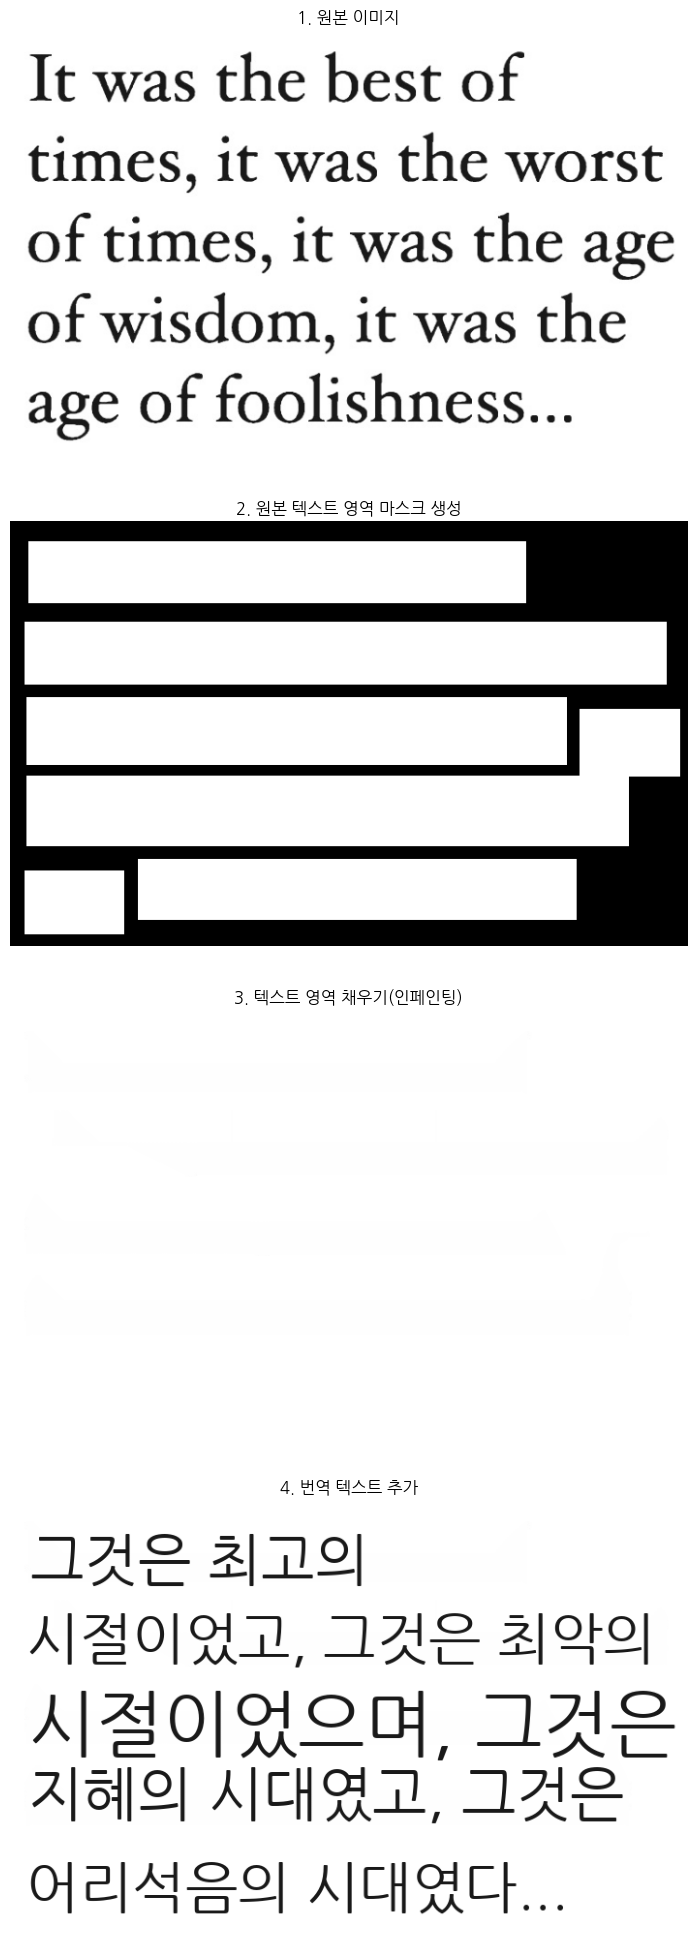

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [134]:
image_path = "test1.png"
source_lang = "en"
target_lang = "ko"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.992, 'metadata': {'pages': [{'height': 440, 'page': 1, 'width': 700}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.992, 'height': 440, 'id': 0, 'text': 'It was the best of \ntimes, it was the worst \nof times, it was the \nage \nof wisdom, it was the \nage of foolishness...', 'width': 700, 'words': [{'boundingBox': {'vertices': [{'x': 21, 'y': 26}, {'x': 69, 'y': 26}, {'x': 69, 'y': 74}, {'x': 21, 'y': 74}]}, 'confidence': 0.9936, 'id': 0, 'text': 'It'}, {'boundingBox': {'vertices': [{'x': 86, 'y': 38}, {'x': 188, 'y': 26}, {'x': 194, 'y': 71}, {'x': 91, 'y': 83}]}, 'confidence': 0.9888, 'id': 1, 'text': 'was'}, {'boundingBox': {'vertices': [{'x': 211, 'y': 25}, {'x': 306, 'y': 24}, {'x': 306, 'y': 72}, {'x': 212, 'y': 73}]}, 'confidence': 0.9983, 'id': 2, 'text': 'the'}, {'boundingBox': {'vertices': [{'x': 327, 'y': 25}, {'x': 447, 'y': 25}, {'x': 447, 'y': 74}, {'x': 

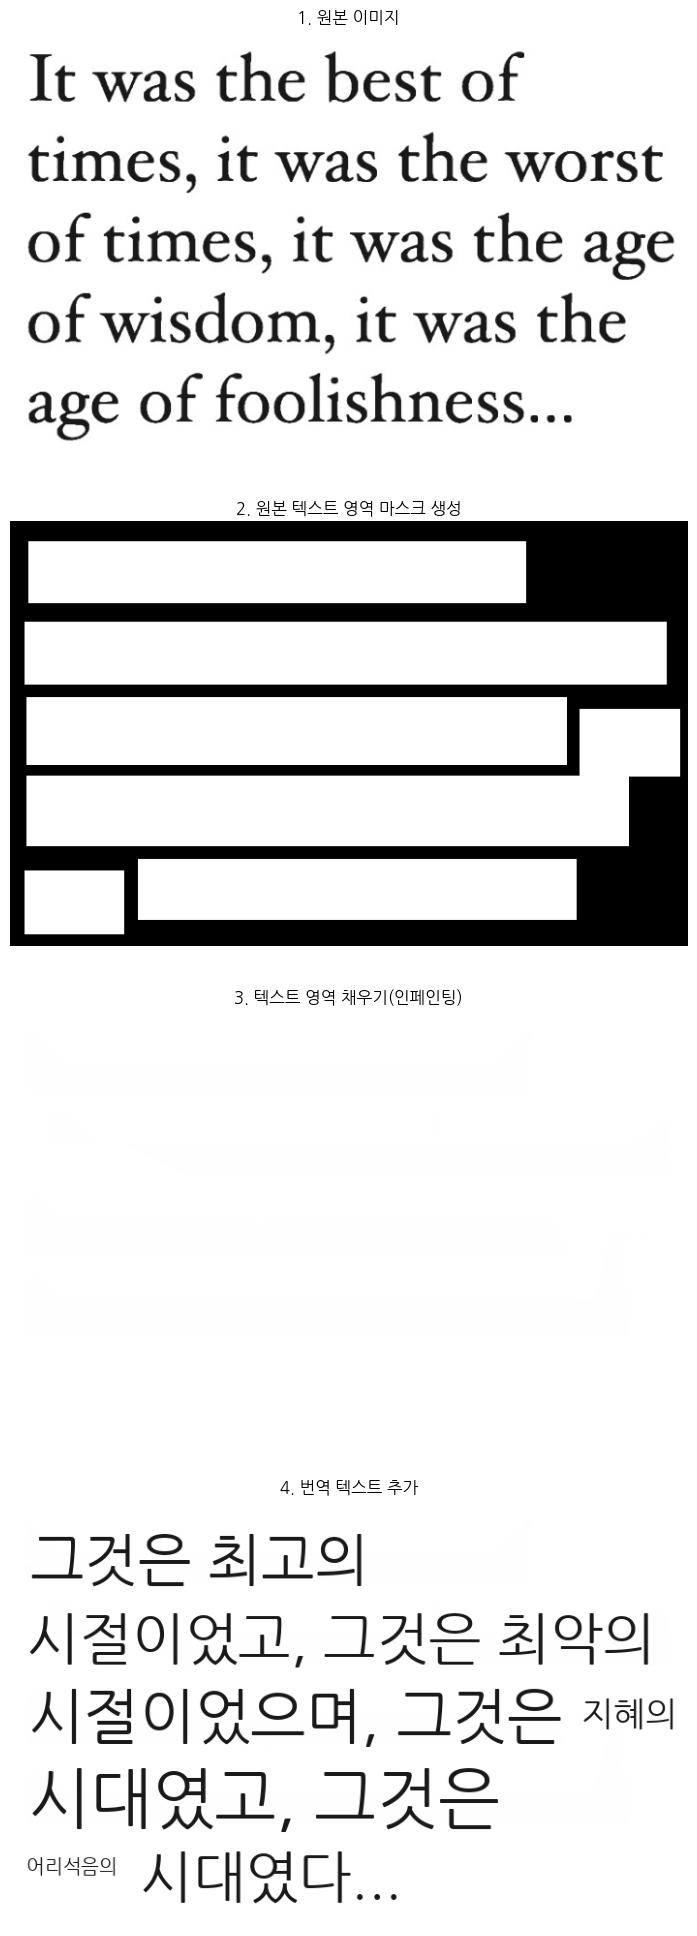

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [132]:
image_path = "test1.png"
source_lang = "en"
target_lang = "ko"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.9578, 'metadata': {'pages': [{'height': 232, 'page': 1, 'width': 350}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.9578, 'height': 232, 'id': 0, 'text': '구민의침해된 권익구제및 불편사항 해소를 위한 \n고충민원 상담관 \n모집기간:2025. 1.3. (금) N 2025. 1.13.(월) 18:00 \n접수방법: 방문 또는 우편 접수 \n문의:강동구청 감사담당관(02- 3425-5019) \n* 모집안내: 강동구청 홈페이지채용공고란 참조', 'width': 350, 'words': [{'boundingBox': {'vertices': [{'x': 47, 'y': 21}, {'x': 123, 'y': 21}, {'x': 123, 'y': 35}, {'x': 47, 'y': 35}]}, 'confidence': 0.9838, 'id': 0, 'text': '구민의침해된'}, {'boundingBox': {'vertices': [{'x': 125, 'y': 21}, {'x': 188, 'y': 21}, {'x': 188, 'y': 35}, {'x': 125, 'y': 35}]}, 'confidence': 0.9069, 'id': 1, 'text': '권익구제및'}, {'boundingBox': {'vertices': [{'x': 191, 'y': 21}, {'x': 279, 'y': 21}, {'x': 279, 'y': 35}, {'x': 191, 'y': 35}]}, 'confidence': 0.9527, 'id': 2, 'text': '불편사항 해소를'}, {'boundingBox': {'vertices': [{'x': 281, 'y'

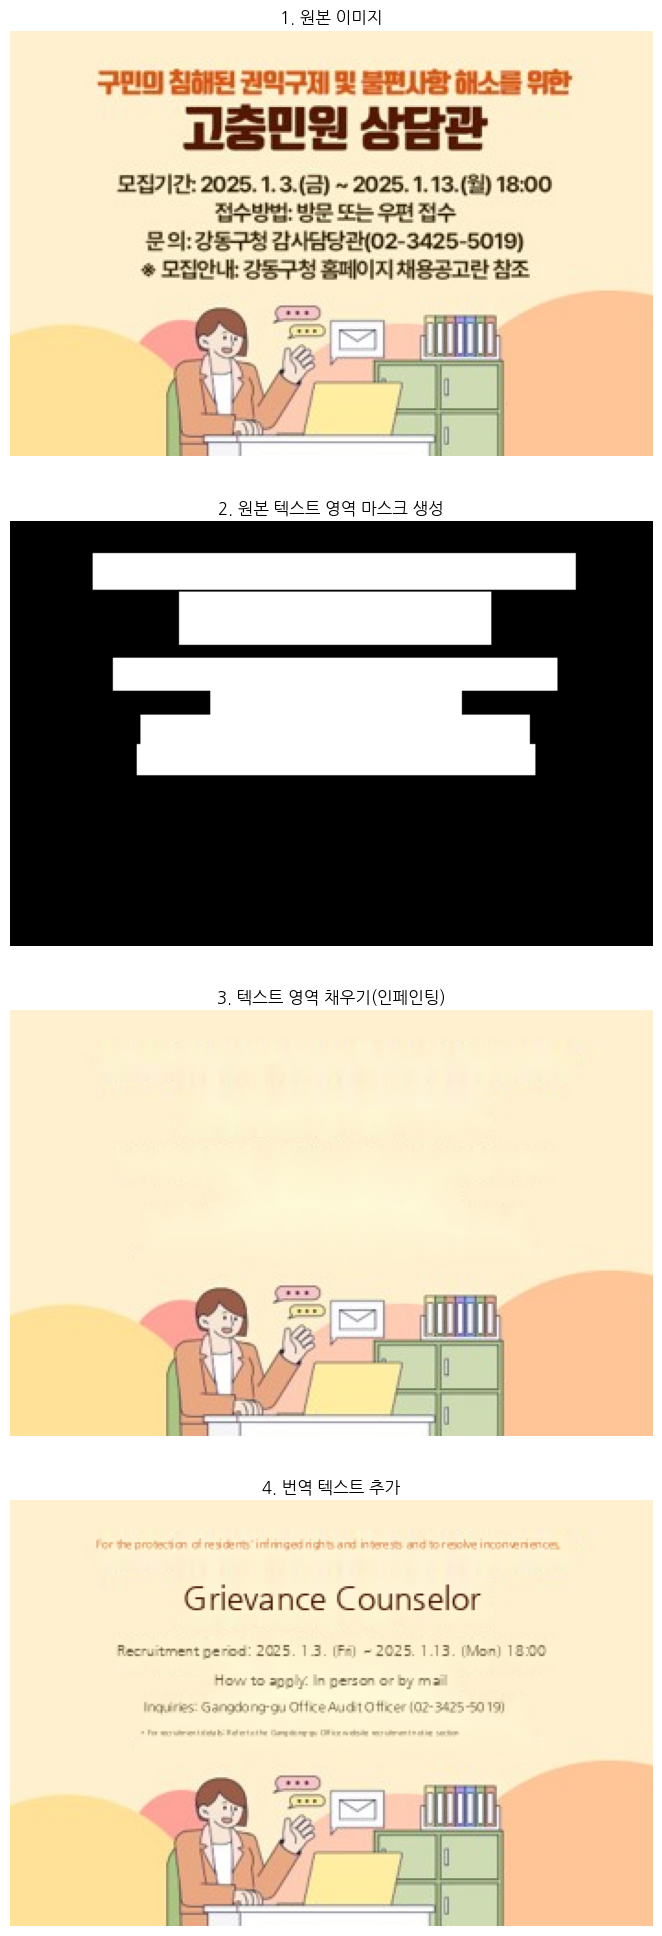

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [135]:
image_path = "test3.jpg"
source_lang = "ko"
target_lang = "en"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.9578, 'metadata': {'pages': [{'height': 232, 'page': 1, 'width': 350}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.9578, 'height': 232, 'id': 0, 'text': '구민의침해된 권익구제및 불편사항 해소를 위한 \n고충민원 상담관 \n모집기간:2025. 1.3. (금) N 2025. 1.13.(월) 18:00 \n접수방법: 방문 또는 우편 접수 \n문의:강동구청 감사담당관(02- 3425-5019) \n* 모집안내: 강동구청 홈페이지채용공고란 참조', 'width': 350, 'words': [{'boundingBox': {'vertices': [{'x': 47, 'y': 21}, {'x': 123, 'y': 21}, {'x': 123, 'y': 35}, {'x': 47, 'y': 35}]}, 'confidence': 0.9838, 'id': 0, 'text': '구민의침해된'}, {'boundingBox': {'vertices': [{'x': 125, 'y': 21}, {'x': 188, 'y': 21}, {'x': 188, 'y': 35}, {'x': 125, 'y': 35}]}, 'confidence': 0.9069, 'id': 1, 'text': '권익구제및'}, {'boundingBox': {'vertices': [{'x': 191, 'y': 21}, {'x': 279, 'y': 21}, {'x': 279, 'y': 35}, {'x': 191, 'y': 35}]}, 'confidence': 0.9527, 'id': 2, 'text': '불편사항 해소를'}, {'boundingBox': {'vertices': [{'x': 281, 'y'

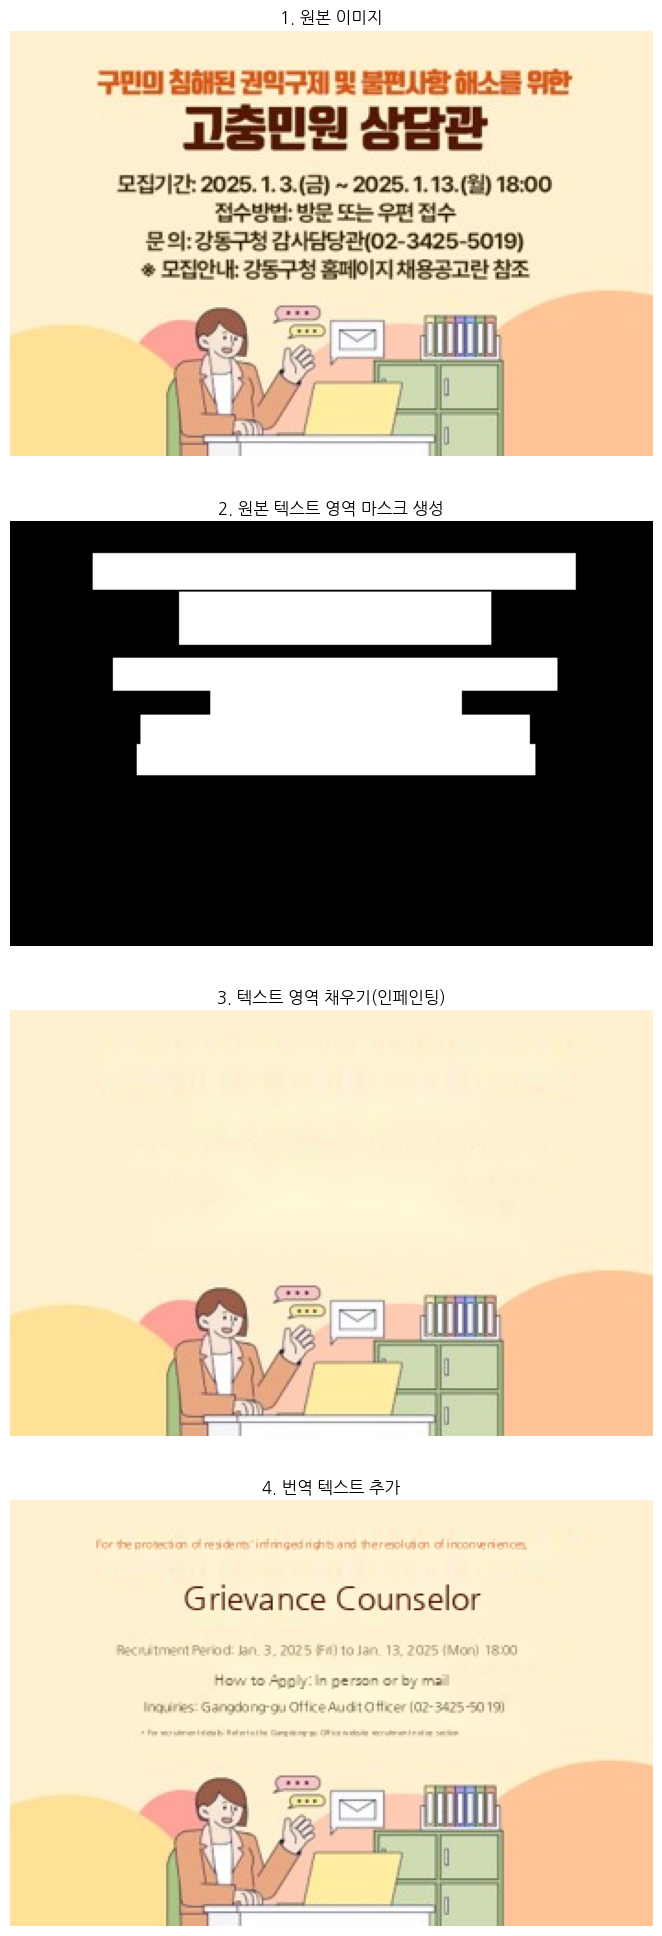

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [131]:
image_path = "test3.jpg"
source_lang = "ko"
target_lang = "en"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.98, 'metadata': {'pages': [{'height': 136, 'page': 1, 'width': 521}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.98, 'height': 136, 'id': 0, 'text': '타고 1개월 단위로 \ntago.kr \n전기차가 필요할 때! \n타고 월렌트 \n070-5067-3100/www.tago.kr', 'width': 521, 'words': [{'boundingBox': {'vertices': [{'x': 57, 'y': 15}, {'x': 93, 'y': 15}, {'x': 93, 'y': 31}, {'x': 57, 'y': 31}]}, 'confidence': 0.9852, 'id': 0, 'text': '타고'}, {'boundingBox': {'vertices': [{'x': 387, 'y': 18}, {'x': 435, 'y': 18}, {'x': 435, 'y': 37}, {'x': 387, 'y': 37}]}, 'confidence': 0.9822, 'id': 1, 'text': '1개월'}, {'boundingBox': {'vertices': [{'x': 442, 'y': 18}, {'x': 497, 'y': 18}, {'x': 497, 'y': 36}, {'x': 442, 'y': 36}]}, 'confidence': 0.9939, 'id': 2, 'text': '단위로'}, {'boundingBox': {'vertices': [{'x': 56, 'y': 32}, {'x': 93, 'y': 32}, {'x': 93, 'y': 40}, {'x': 56, 'y': 40}]}, 'confidence': 0.9976, 'id': 3, 'text'

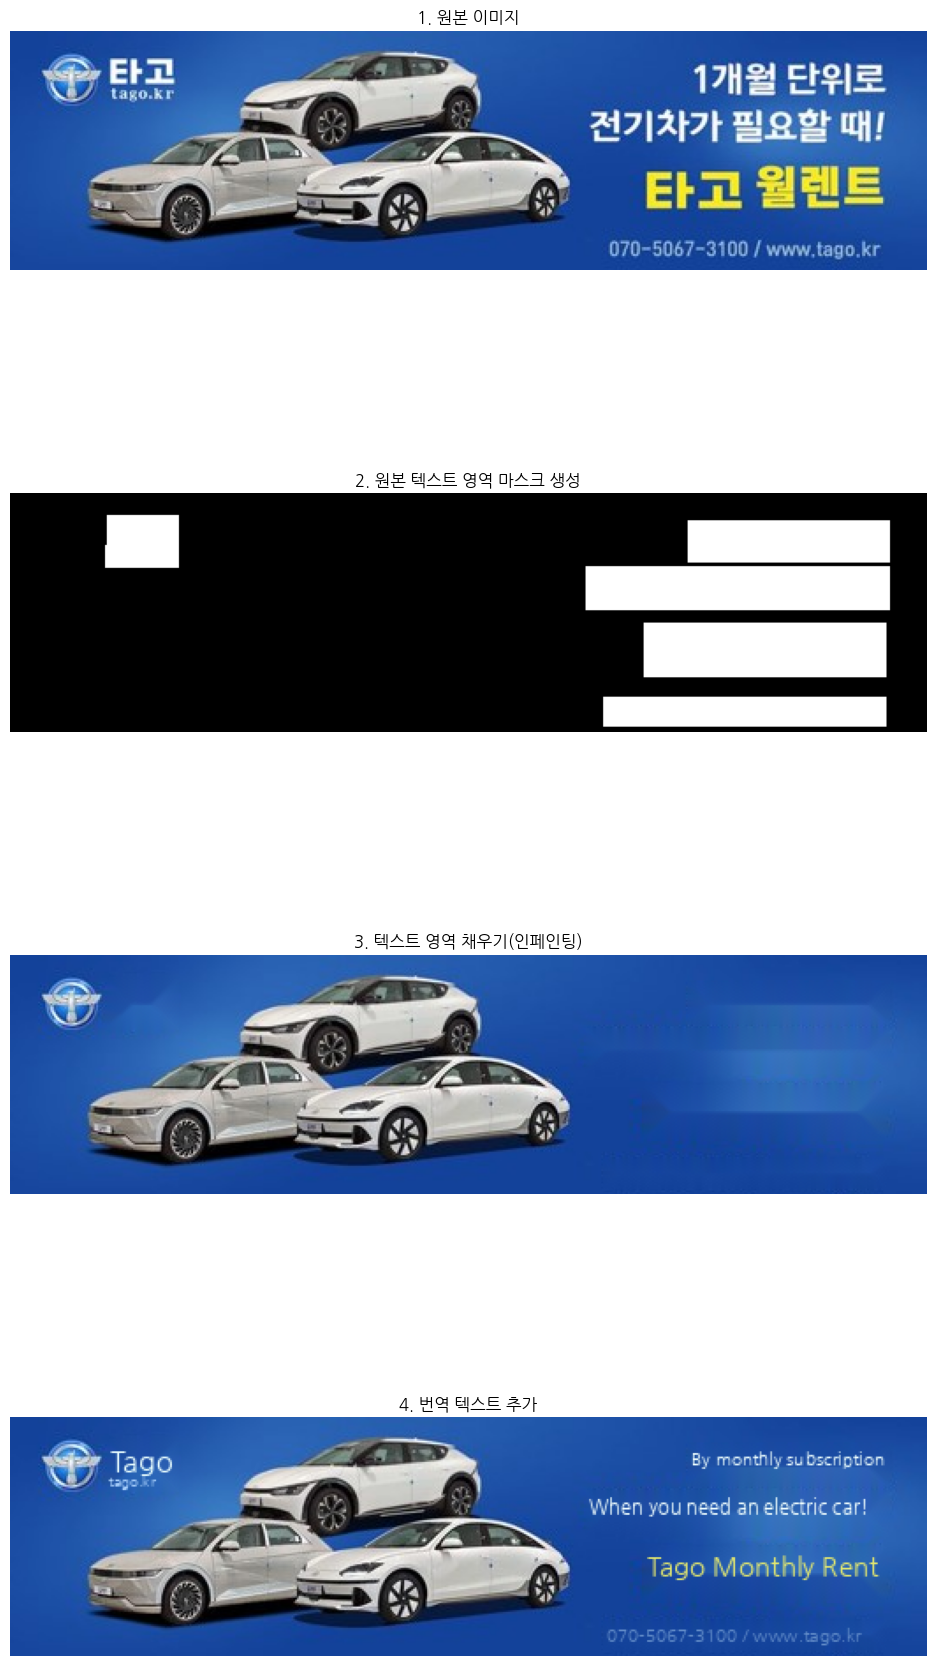

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [136]:
image_path = "test2.jpg"
source_lang = "ko"
target_lang = "en"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.98, 'metadata': {'pages': [{'height': 136, 'page': 1, 'width': 521}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.98, 'height': 136, 'id': 0, 'text': '타고 1개월 단위로 \ntago.kr \n전기차가 필요할 때! \n타고 월렌트 \n070-5067-3100/www.tago.kr', 'width': 521, 'words': [{'boundingBox': {'vertices': [{'x': 57, 'y': 15}, {'x': 93, 'y': 15}, {'x': 93, 'y': 31}, {'x': 57, 'y': 31}]}, 'confidence': 0.9852, 'id': 0, 'text': '타고'}, {'boundingBox': {'vertices': [{'x': 387, 'y': 18}, {'x': 435, 'y': 18}, {'x': 435, 'y': 37}, {'x': 387, 'y': 37}]}, 'confidence': 0.9822, 'id': 1, 'text': '1개월'}, {'boundingBox': {'vertices': [{'x': 442, 'y': 18}, {'x': 497, 'y': 18}, {'x': 497, 'y': 36}, {'x': 442, 'y': 36}]}, 'confidence': 0.9939, 'id': 2, 'text': '단위로'}, {'boundingBox': {'vertices': [{'x': 56, 'y': 32}, {'x': 93, 'y': 32}, {'x': 93, 'y': 40}, {'x': 56, 'y': 40}]}, 'confidence': 0.9976, 'id': 3, 'text'

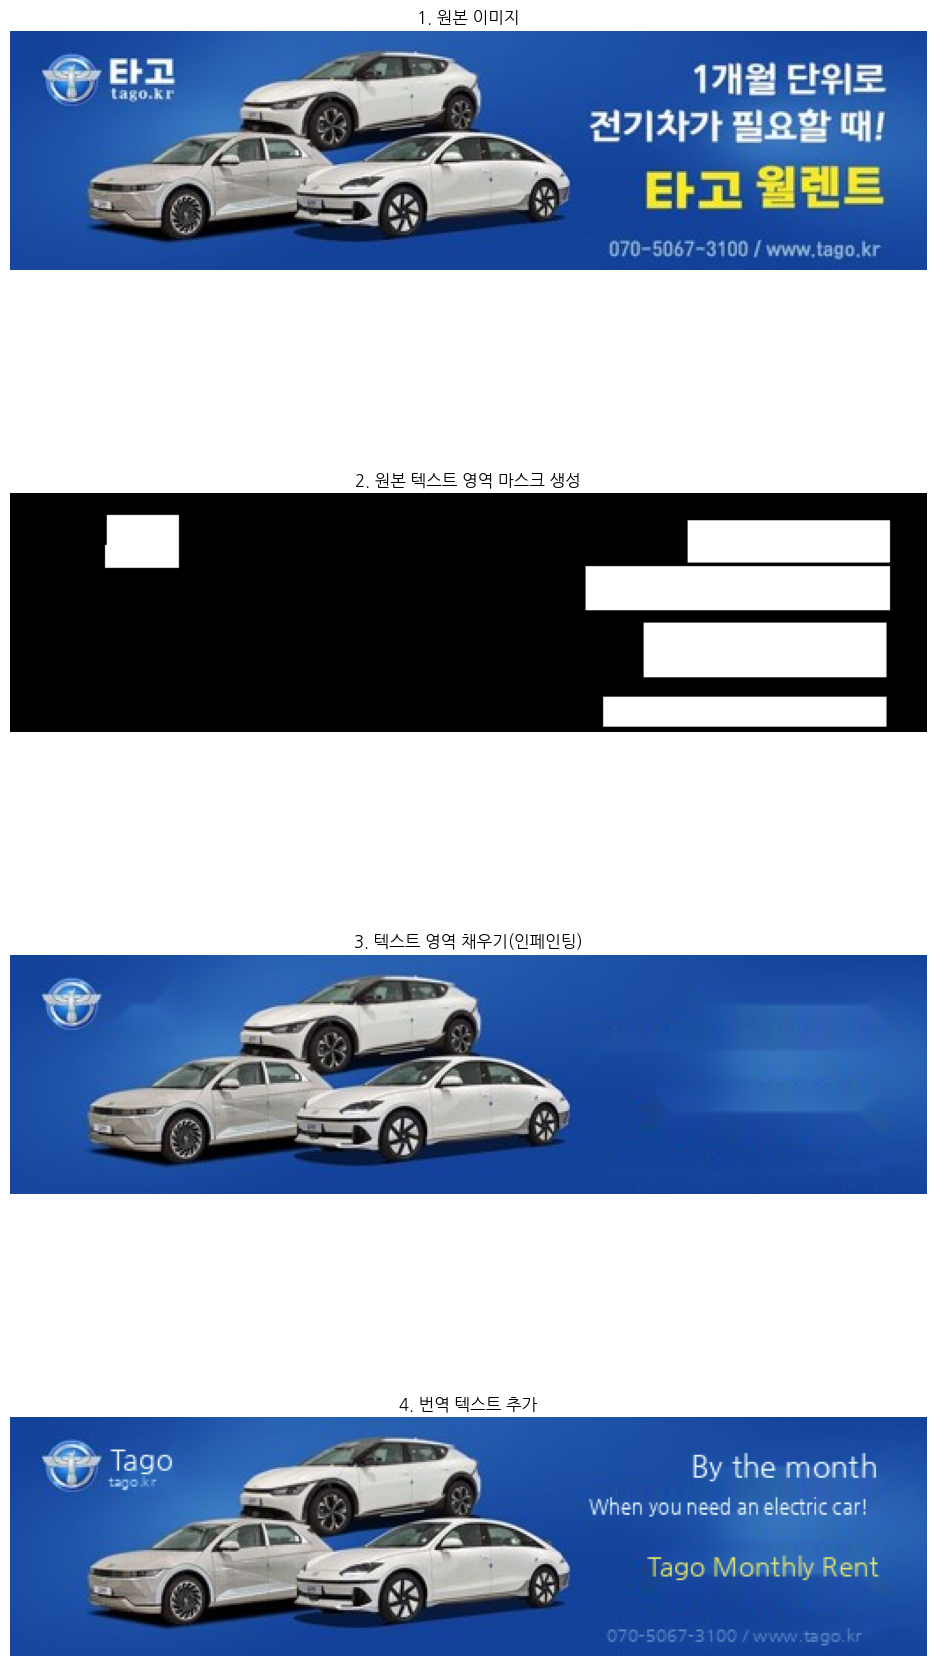

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [91]:
image_path = "test2.jpg"
source_lang = "ko"
target_lang = "en"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.9805, 'metadata': {'pages': [{'height': 320, 'page': 1, 'width': 220}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.9805, 'height': 320, 'id': 0, 'text': 'Tomorrow, and \ntomorrow, and \ntomorrow; creeps \nthis petty pace \nin \nday, \nfrom day \nto \nsyll- \nuntil the last \nable of recorded \ntime. And all our \nyesterdays have \nlighted fools the \ndusty \nway \nto', 'width': 220, 'words': [{'boundingBox': {'vertices': [{'x': 10, 'y': 17}, {'x': 131, 'y': 23}, {'x': 130, 'y': 41}, {'x': 9, 'y': 35}]}, 'confidence': 0.9827, 'id': 0, 'text': 'Tomorrow,'}, {'boundingBox': {'vertices': [{'x': 136, 'y': 18}, {'x': 178, 'y': 16}, {'x': 178, 'y': 35}, {'x': 137, 'y': 36}]}, 'confidence': 0.9916, 'id': 1, 'text': 'and'}, {'boundingBox': {'vertices': [{'x': 9, 'y': 43}, {'x': 124, 'y': 50}, {'x': 124, 'y': 67}, {'x': 8, 'y': 61}]}, 'confidence': 0.9578, 'id': 2, 'text': 'tomo

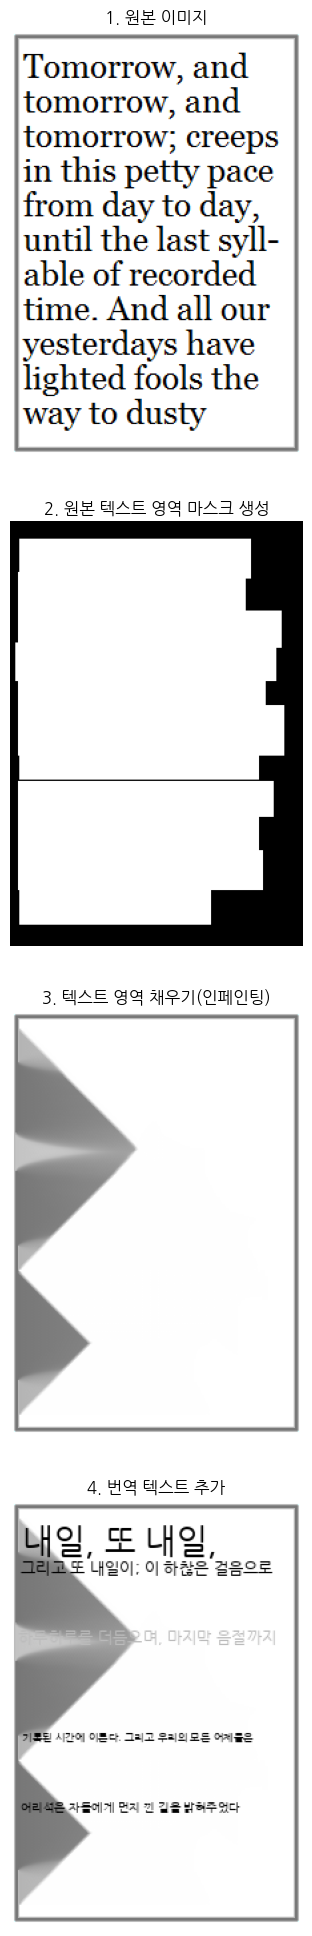

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [140]:
image_path = "테스트 이미지3(영문).png"
source_lang = "en"
target_lang = "ko"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

## 자동 텍스트 제거(Clipdrop)를 사용

In [163]:
import requests
from io import BytesIO

def auto_text_removal(image_path):
    # 확장자 확인
    ext = os.path.splitext(image_path)[1].lower()

    if ext == '.webp':
        # webp 이미지를 열어서 png로 변환
        with Image.open(image_path) as im:
            buf = BytesIO()
            im.save(buf, format='PNG')
            buf.seek(0)
            image_file_object = buf
            filename = 'image.png'
            mime_type = 'image/png'
    else:
        # webp가 아니면 원본 파일 그대로 사용
        image_file_object = open(image_path, 'rb')
        filename = os.path.basename(image_path)
        # 확장자에 따라 mime_type 지정
        mime_type = {
            '.png': 'image/png',
            '.jpg': 'image/jpeg',
            '.jpeg': 'image/jpeg',
            '.bmp': 'image/bmp'
        }.get(ext, 'application/octet-stream')

    r = requests.post('https://clipdrop-api.co/remove-text/v1',
    files = {
        'image_file': ('image.webp', image_file_object, 'image/webp')
        },
    headers = { 'x-api-key': os.getenv('CLIPDROP_API_KEY')}
    )
    if (r.ok):
        # r.content contains the bytes of the returned image
        image_file_object = BytesIO(r.content)
        image = Image.open(image_file_object)
        image.show()
        image.save('test_clipdrop.webp')
        return image
    else:
        r.raise_for_status()

In [174]:
def process_image_with_steps_v2(image_path, image, original_results, translated_results, font_path):
    # 1. 원본 이미지 로드
    original_image = image.copy()
    inpainted_image = auto_text_removal(image_path)
    
    # numpy 배열로 변환
    np_inpainted_image = np.array(inpainted_image)
    np_original_image = np.array(original_image)
    
    translated_image = inpainted_image.copy()
    draw = ImageDraw.Draw(translated_image)
    
    for bbox, translated_text in translated_results:
        # 바운딩 박스 크기 계산
        x1, y1 = bbox[0]
        x2, y2 = bbox[2]
        bbox_width = abs(x2 - x1)
        bbox_height = abs(y2 - y1)

        # 폰트 크기 조정
        font_size = bbox_height
        font = ImageFont.truetype(font_path, font_size)

        # 텍스트 크기 측정 및 조정
        text_bbox = draw.textbbox((0, 0), translated_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        while text_width > bbox_width + 4 and font_size > 1:
            font_size -= 1
            font = ImageFont.truetype(font_path, font_size)
            text_bbox = draw.textbbox((0, 0), translated_text, font=font)
            text_width = text_bbox[2] - text_bbox[0]

        # 텍스트 색상 추출
        bgr_color = get_text_color(np_inpainted_image, original_image, bbox)
        rgb_color = (bgr_color[2], bgr_color[1], bgr_color[0])  # BGR → RGB

        print(f"좌표: {bbox}, 텍스트: '{translated_text}', 색상: {rgb_color}, 크기: {font_size}")

        # 텍스트 위치 조정 (바운딩 박스의 x, y 사용)
        x = x1
        y = y1 + (bbox_height - text_height) // 2  # 중앙정렬
        
        # 텍스트 그리기
        draw.text((x, y), translated_text, font=font, fill=rgb_color)

    return translated_image

In [168]:
def translate_image_v2(image_path, source_lang, target_lang, model):
    try:
        # 1. 이미지 로드
        with open(image_path, 'rb') as file:
            contents = file.read()
        nparr = np.frombuffer(contents, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # 2. OCR 결과 추출
        ocr_results = ocr_image_upstage(image_path)
        print("✅ OCR 텍스트 추출 완료! (1/5)")

        # 3. 프롬프트 및 모델 설정
        prompt = load_prompt("../translate_image_upstage_v3.yaml", encoding="utf-8")
        llm, model_name = get_model_by_name(model)
        chain = prompt | llm
        print("✅ 모델 설정 완료! (2/5)")

        # 4. 모델 실행
        translated_texts = chain.invoke({
            "OCR_RESULTS": ocr_results,
            "source_lang": source_lang,
            "target_lang": target_lang
        })
        print("✅ 추출된 텍스트 번역 완료! (3/5)")

        # 5. 결과 정제
        cleaned_translated_texts = clean_content(translated_texts.content)
        # 먼저 문자열 형태 확인
        print("변환 전 문자열 형태:", repr(cleaned_translated_texts))
        
        # 문자열이 올바른 형식인지 확인하고 필요하면 수정
        if not cleaned_translated_texts.startswith('[') or not cleaned_translated_texts.endswith(']'):
            # 대괄호로 감싸지 않은 경우 추가
            cleaned_translated_texts = '[' + cleaned_translated_texts + ']'
        
        # 문자열을 Python 객체로 변환
        cleaned_translated_texts = ast.literal_eval(cleaned_translated_texts)
        print(f"✅ Cleaned Translated Texts :")
        for i in cleaned_translated_texts:
            print(i)
        print("✅ 결과 정제 완료! (4/5)")


        # 6. 번역된 텍스트 이미지 생성
        font_path = "C:/Users/COM-PPJU/Desktop/JDH/chatty/AI-Translation/fonts/NanumGothic.ttf"
        pil_image = process_image_with_steps_v2(image_path, image, ocr_results, cleaned_translated_texts, font_path)
        print("✅ 번역된 텍스트 이미지 생성 완료! (5/5)")

        # 7. 결과 이미지 반환
        return pil_image

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        return None

In [175]:
image_path = "테스트 이미지3(영문).png"
source_lang = "en"
target_lang = "ko"
model = "gpt-4.1"

final_image = translate_image_v2(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")

원본 OCR 결과: {'apiVersion': '1.1', 'confidence': 0.9805, 'metadata': {'pages': [{'height': 320, 'page': 1, 'width': 220}]}, 'mimeType': 'multipart/form-data', 'modelVersion': 'ocr-2.2.1', 'numBilledPages': 1, 'pages': [{'confidence': 0.9805, 'height': 320, 'id': 0, 'text': 'Tomorrow, and \ntomorrow, and \ntomorrow; creeps \nthis petty pace \nin \nday, \nfrom day \nto \nsyll- \nuntil the last \nable of recorded \ntime. And all our \nyesterdays have \nlighted fools the \ndusty \nway \nto', 'width': 220, 'words': [{'boundingBox': {'vertices': [{'x': 10, 'y': 17}, {'x': 131, 'y': 23}, {'x': 130, 'y': 41}, {'x': 9, 'y': 35}]}, 'confidence': 0.9827, 'id': 0, 'text': 'Tomorrow,'}, {'boundingBox': {'vertices': [{'x': 136, 'y': 18}, {'x': 178, 'y': 16}, {'x': 178, 'y': 35}, {'x': 137, 'y': 36}]}, 'confidence': 0.9916, 'id': 1, 'text': 'and'}, {'boundingBox': {'vertices': [{'x': 9, 'y': 43}, {'x': 124, 'y': 50}, {'x': 124, 'y': 67}, {'x': 8, 'y': 61}]}, 'confidence': 0.9578, 'id': 2, 'text': 'tomo